# GradientBoost Experiment

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ieee-fraud-detection/sample_submission.csv
/kaggle/input/ieee-fraud-detection/test_identity.csv
/kaggle/input/ieee-fraud-detection/train_identity.csv
/kaggle/input/ieee-fraud-detection/test_transaction.csv
/kaggle/input/ieee-fraud-detection/train_transaction.csv


In [2]:
!pip install --upgrade scikit-learn==1.3.2 imbalanced-learn==0.11.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 83.6 MB/s eta 0:00:00:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 12.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstalled imbalanced-learn-0.13.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nilearn 0.11.1 requires scikit-learn>=1.4.0, but you have scikit-learn 1.3.2 which is incompatible.
bigframes 1.36.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.


# Constants

In [3]:
NA_DROP_THRESHOLD = 0.5
CORRELATION_FILTER_THRESHOLD=0.8
KFOLD_N_SPLITS = 3
RANDOM_STATE=42
DATASET_SPLIT_SIZE=0.2

# Dagshub Setup

In [4]:
!pip install mlflow dagshub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 61.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 100.1 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.1/260.1 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 692.3/692.3 kB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.3/74.3 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 3.6 MB/s eta 0:00:00
  Attempting uninstall: dacite
    Found existing installation: dacite 1.9.2
    Uninstalling dacite-1.9.2:
      

In [5]:
import dagshub
dagshub.auth.add_app_token('ed22b8f88bed7c968c7425f62448b33703f4e094')
dagshub.init(repo_owner='vvaza22', repo_name='ml-assignment-2', mlflow=True)

Accessing as vvaza22

Initialized MLflow to track repo "vvaza22/ml-assignment-2"

Repository vvaza22/ml-assignment-2 initialized!

In [6]:
import mlflow

def log_model(run_name, params, metrics, best_pipeline, figures=[]):
    mlflow.set_experiment("GradientBoost_Training")
    mlflow.set_tracking_uri("https://dagshub.com/vvaza22/ml-assignment-2.mlflow")
    
    with mlflow.start_run(run_name=run_name):
        mlflow.log_params(params)
        mlflow.log_metrics(metrics)
        mlflow.sklearn.log_model(best_pipeline, "GradientBoost")
        for artifact in figures:
            mlflow.log_artifact(f"/kaggle/working/{artifact}")

# Load Dataset

In [7]:
# Load each data table
transactions = pd.read_csv("/kaggle/input/ieee-fraud-detection/train_transaction.csv")
identities = pd.read_csv("/kaggle/input/ieee-fraud-detection/train_identity.csv")

# Merge data tables
df = pd.merge(transactions, identities, on="TransactionID", how="left")

# Free up memory
del transactions
del identities

In [8]:
# Separate features and target values
y_total = df["isFraud"]
X_total = df.drop(columns=["isFraud"])

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_total, y_total, test_size=DATASET_SPLIT_SIZE, random_state=RANDOM_STATE)

# Cleaning

In [10]:
from sklearn.base import BaseEstimator, TransformerMixin

class DropHighNAFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, threshold):
        self._feats_to_drop = []
        self.threshold = threshold
    
    def fit(self, X, y=None):
        
        na_dist = X.isna().mean()
        for feat, na_ratio in na_dist.items():
            if na_ratio > self.threshold:
                self._feats_to_drop.append(feat)
        
        return self

    def transform(self, X):
        X = X.copy()

        # Drop features with high NA content
        X.drop(columns=self._feats_to_drop, inplace=True)

        return X

In [11]:
from sklearn.base import BaseEstimator, TransformerMixin

class FillNAWithMedian(BaseEstimator, TransformerMixin):
    def __init__(self):
        self._na_mapping = {}
    
    def fit(self, X, y=None):
        
        for feat in X.columns:
            median = X[feat].median()
            self._na_mapping[feat] = median
        
        return self

    def transform(self, X):
        X = X.copy()

        for feat, value in self._na_mapping.items():
            X[feat] = X[feat].fillna(value)
        
        return X

# Feature Engineering

In [12]:
import category_encoders

# Find every categorical feature in the data
cat_feats = [feat for feat in X_total.columns if X_total[feat].dtype == "object"]

# Create woe encoder for the features
woe_encoder = category_encoders.WOEEncoder(cols=cat_feats)

## Helper functions

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc(model, X, y):
    
    # Predict probabilities
    y_prob = model.predict_proba(X)[:, 1]
    fpr, tpr, thresholds = roc_curve(y, y_prob)
    auc_score = auc(fpr, tpr)
    
    plt.figure(figsize=(10, 8))
    
    plt.title("ROC Curve on Training Set")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    plt.plot(fpr, tpr, color="blue")
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

    plt.tight_layout()
    plt.savefig(f"gradientboost_roc_curve.png")
    plt.show()

    # Draw Mirrored ROC curve
    tnr = 1 - fpr
    plt.figure(figsize=(10, 8))
    
    plt.title("Mirrored ROC Curve on Training Set")
    plt.xlabel('True Negative Rate')
    plt.ylabel('True Positive Rate')
    
    plt.plot(tnr, tpr, color="red")
    plt.plot([0, 1], [1, 0], color='gray', linestyle='--')

    plt.tight_layout()
    plt.savefig(f"gradientboost_roc_curve_mirrored.png")
    plt.show()

In [14]:
def get_metrics(grid_search):
    results = pd.DataFrame(grid_search.cv_results_)
    
    # Get the best result from the grid search
    best_result = results.sort_values(by="rank_test_score").iloc[0].to_dict()

    # Remove parameter values
    keys_to_drop = []
    for key in best_result.keys():
        if key.startswith("param"):
            keys_to_drop.append(key)
    
    for key in keys_to_drop:
        del best_result[key]

    del best_result["rank_test_score"]

    return best_result

# Experiment 1: Handling Imbalance with scale_pos_weight

## Training

In [16]:
# Specify parameters to try using GridSearch
param_grid = {
    "classifier__max_depth": [3],
    "classifier__n_estimators": [30],
    "classifier__learning_rate": [0.1, 0.5, 1, 1.5],
    "classifier__max_features": [10, 20, 30]
}

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(
    random_state=RANDOM_STATE
)
pipeline = Pipeline([
    ('woe_encoder', woe_encoder),
    ('drop_high_na_feats', DropHighNAFeatures(threshold=NA_DROP_THRESHOLD)),
    ('fill_na_with_median', FillNAWithMedian()),
    ('scaler', StandardScaler()),
    ('classifier', model),
])

In [18]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Prepare GridSearch
kfold = StratifiedKFold(n_splits=KFOLD_N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
grid_search = GridSearchCV(pipeline, param_grid, cv=kfold, scoring='roc_auc', return_train_score=True, verbose=3)

In [19]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3] END classifier__learning_rate=0.1, classifier__max_depth=3, classifier__max_features=10, classifier__n_estimators=30;, score=(train=0.847, test=0.845) total time=  29.2s
[CV 2/3] END classifier__learning_rate=0.1, classifier__max_depth=3, classifier__max_features=10, classifier__n_estimators=30;, score=(train=0.847, test=0.848) total time=  28.4s
[CV 3/3] END classifier__learning_rate=0.1, classifier__max_depth=3, classifier__max_features=10, classifier__n_estimators=30;, score=(train=0.848, test=0.845) total time=  28.3s
[CV 1/3] END classifier__learning_rate=0.1, classifier__max_depth=3, classifier__max_features=20, classifier__n_estimators=30;, score=(train=0.855, test=0.853) total time=  33.0s
[CV 2/3] END classifier__learning_rate=0.1, classifier__max_depth=3, classifier__max_features=20, classifier__n_estimators=30;, score=(train=0.851, test=0.851) total time=  33.4s
[CV 3/3] END classifier__learning_rate=0.1, 

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('woe_encoder',
                                        WOEEncoder(cols=['ProductCD', 'card4',
                                                         'card6',
                                                         'P_emaildomain',
                                                         'R_emaildomain', 'M1',
                                                         'M2', 'M3', 'M4', 'M5',
                                                         'M6', 'M7', 'M8', 'M9',
                                                         'id_12', 'id_15',
                                                         'id_16', 'id_23',
                                                         'id_27', 'id_28',
                                                         'id_29', 'id_30',
                                                         'id_31', 'id_33',
                                                         'id_34', 'id_35',
                                                         'id_36', 'id_37',
                                                         'i...
                                        DropHighNAFeatures(threshold=0.5)),
                                       ('fill_na_with_median',
                                        FillNAWithMedian()),
                                       ('scaler', StandardScaler()),
                                       ('classifier',
                                        GradientBoostingClassifier(random_state=42))]),
             param_grid={'classifier__learning_rate': [0.1, 0.5, 1, 1.5],
                         'classifier__max_depth': [3],
                         'classifier__max_features': [10, 20, 30],
                         'classifier__n_estimators': [30]},
             return_train_score=True, scoring='roc_auc', verbose=3)

In [20]:
grid_search.best_score_

0.8670516628046139

In [21]:
grid_search.best_params_

{'classifier__learning_rate': 0.5,
 'classifier__max_depth': 3,
 'classifier__max_features': 20,
 'classifier__n_estimators': 30}

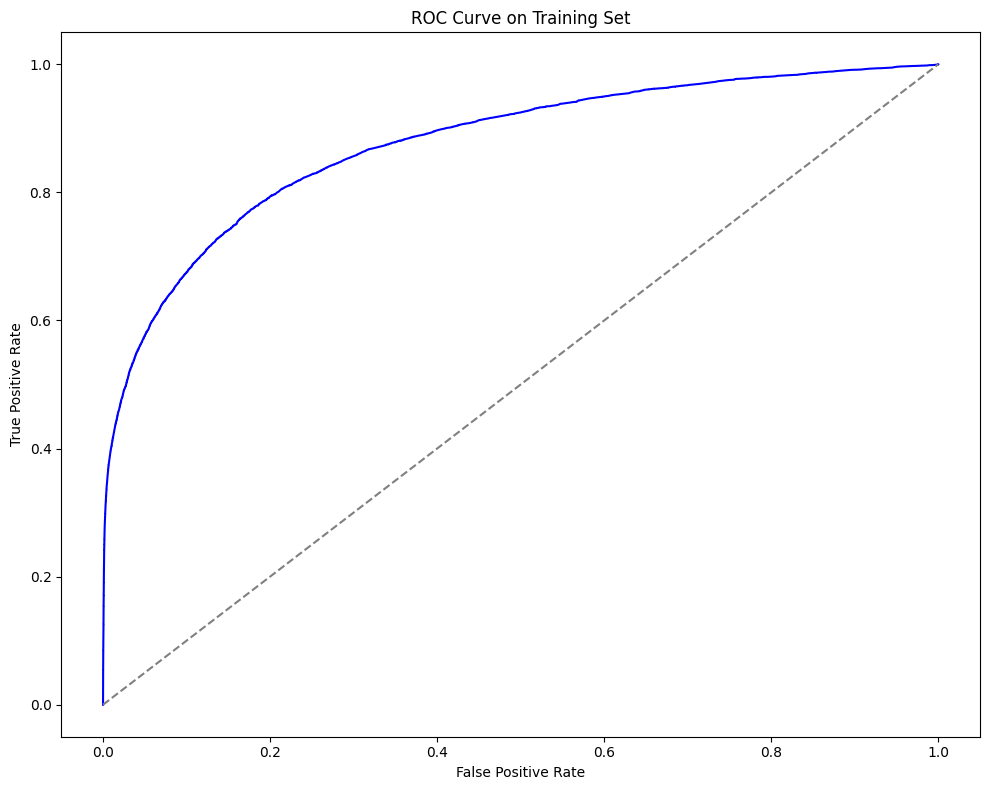

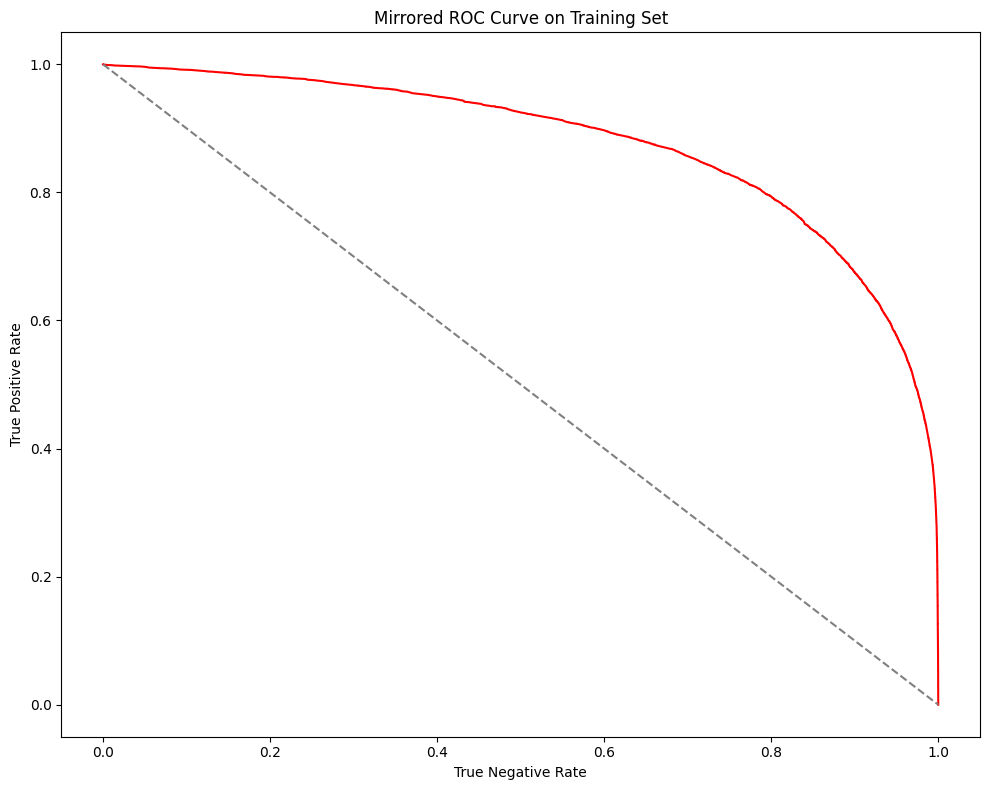

In [22]:
best_pipeline = grid_search.best_estimator_
plot_roc(best_pipeline, X_train, y_train)

# Logging Model

In [23]:
# https://mlflow.org/docs/latest/traditional-ml/creating-custom-pyfunc/notebooks/override-predict/

class ProbabilityModel(mlflow.pyfunc.PythonModel):
    def __init__(self, model):
        self.model = model

    def load_context(self, context):
        pass

    def predict(self, context, model_input, params=None):
        return self.model.predict_proba(model_input)[:, 1]

/usr/local/lib/python3.11/dist-packages/mlflow/pyfunc/utils/data_validation.py:186: UserWarning: Add type hints to the `predict` method to enable data validation and automatic signature inference during model logging. Check https://mlflow.org/docs/latest/model/python_model.html#type-hint-usage-in-pythonmodel for more details.
  color_warning(


In [24]:
def log_custom_pymodel(run_name, params, metrics, best_pipeline, figures=[]):
    mlflow.set_experiment("GradientBoost_Training")
    mlflow.set_tracking_uri("https://dagshub.com/vvaza22/ml-assignment-2.mlflow")
    
    with mlflow.start_run(run_name=run_name):
        mlflow.log_params(params)
        mlflow.log_metrics(metrics)
        mlflow.pyfunc.log_model("GradientBoost", python_model=ProbabilityModel(best_pipeline))
        for artifact in figures:
            mlflow.log_artifact(f"/kaggle/working/{artifact}")

In [25]:
params = {
    "random_state": RANDOM_STATE,
    "na_drop_threshold": NA_DROP_THRESHOLD,
    "kfold_n_splits": KFOLD_N_SPLITS,
    **grid_search.best_params_
}
params

{'random_state': 42,
 'na_drop_threshold': 0.5,
 'kfold_n_splits': 3,
 'classifier__learning_rate': 0.5,
 'classifier__max_depth': 3,
 'classifier__max_features': 20,
 'classifier__n_estimators': 30}

In [26]:
from sklearn.metrics import roc_auc_score

# Calculate validation score
best_pipeline = grid_search.best_estimator_
y_prob = best_pipeline.predict_proba(X_test)[:, 1]
auc_test_score = roc_auc_score(y_test, y_prob)
auc_test_score

0.8771065254059726

In [27]:
metrics = get_metrics(grid_search)
metrics["validation_score"] = auc_test_score
metrics

{'mean_fit_time': 29.21183141072591,
 'std_fit_time': 0.1461129266428542,
 'mean_score_time': 3.4612154960632324,
 'std_score_time': 0.10306254414348205,
 'split0_test_score': 0.8674812440276053,
 'split1_test_score': 0.8665260309126757,
 'split2_test_score': 0.8671477134735609,
 'mean_test_score': 0.8670516628046139,
 'std_test_score': 0.00039583441149657495,
 'split0_train_score': 0.8700788989064704,
 'split1_train_score': 0.871753929991365,
 'split2_train_score': 0.8725453022976153,
 'mean_train_score': 0.8714593770651501,
 'std_train_score': 0.0010282209528173858,
 'validation_score': 0.8771065254059726}

In [36]:
best_pipeline = grid_search.best_estimator_

In [28]:
log_model(
    run_name="GradientBoost_Model_2",
    params=params,
    metrics=metrics,
    best_pipeline=best_pipeline,
    figures=["gradientboost_roc_curve.png", "gradientboost_roc_curve_mirrored.png"]
)

2025/04/28 13:57:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run GradientBoost_Model_2 at: https://dagshub.com/vvaza22/ml-assignment-2.mlflow/#/experiments/3/runs/7ee0953e405a4640b1619fb4b057237b
🧪 View experiment at: https://dagshub.com/vvaza22/ml-assignment-2.mlflow/#/experiments/3


In [24]:
log_custom_pymodel(
    run_name="GradientBoost_Prob_Model_2",
    params=params,
    metrics=metrics,
    best_pipeline=best_pipeline,
    figures=["gradientboost_roc_curve.png", "gradientboost_roc_curve_mirrored.png"]
)

NameError: name 'log_custom_pymodel' is not defined

# Experiment 2: Imbalanced Learn

In [15]:
import xgboost as xgb
from imblearn.pipeline import Pipeline as ImbalancedPipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(
    random_state=RANDOM_STATE
)
pipeline = ImbalancedPipeline(steps=[
    ('woe_encoder', woe_encoder),
    ('drop_high_na_feats', DropHighNAFeatures(threshold=NA_DROP_THRESHOLD)),
    ('fill_na', FillNAWithMedian()),
    ('smote', SMOTE(random_state=RANDOM_STATE)),
    ('classifier', model),
])

In [16]:
# Specify parameters to try using GridSearch
param_grid = {
    "classifier__max_depth": [10, 15],
    "classifier__n_estimators": [10, 15],
    "classifier__learning_rate": [0.5],
    "classifier__max_features": [10, 30]
}

In [17]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Prepare GridSearch
kfold = StratifiedKFold(n_splits=KFOLD_N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
grid_search = GridSearchCV(pipeline, param_grid, cv=kfold, scoring='roc_auc', return_train_score=True, verbose=3)

In [18]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV 1/3] END classifier__learning_rate=0.5, classifier__max_depth=10, classifier__max_features=10, classifier__n_estimators=10;, score=(train=0.900, test=0.877) total time= 1.2min
[CV 2/3] END classifier__learning_rate=0.5, classifier__max_depth=10, classifier__max_features=10, classifier__n_estimators=10;, score=(train=0.901, test=0.880) total time= 1.1min
[CV 3/3] END classifier__learning_rate=0.5, classifier__max_depth=10, classifier__max_features=10, classifier__n_estimators=10;, score=(train=0.900, test=0.877) total time= 1.2min
[CV 1/3] END classifier__learning_rate=0.5, classifier__max_depth=10, classifier__max_features=10, classifier__n_estimators=15;, score=(train=0.916, test=0.885) total time= 1.5min
[CV 2/3] END classifier__learning_rate=0.5, classifier__max_depth=10, classifier__max_features=10, classifier__n_estimators=15;, score=(train=0.920, test=0.889) total time= 1.5min
[CV 3/3] END classifier__learning_rate=0

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('woe_encoder',
                                        WOEEncoder(cols=['ProductCD', 'card4',
                                                         'card6',
                                                         'P_emaildomain',
                                                         'R_emaildomain', 'M1',
                                                         'M2', 'M3', 'M4', 'M5',
                                                         'M6', 'M7', 'M8', 'M9',
                                                         'id_12', 'id_15',
                                                         'id_16', 'id_23',
                                                         'id_27', 'id_28',
                                                         'id_29', 'id_30',
                                                         'id_31', 'id_33',
                                                         'id_34', 'id_35',
                                                         'id_36', 'id_37',
                                                         'i...
                                        DropHighNAFeatures(threshold=0.5)),
                                       ('fill_na', FillNAWithMedian()),
                                       ('smote', SMOTE(random_state=42)),
                                       ('classifier',
                                        GradientBoostingClassifier(random_state=42))]),
             param_grid={'classifier__learning_rate': [0.5],
                         'classifier__max_depth': [10, 15],
                         'classifier__max_features': [10, 30],
                         'classifier__n_estimators': [10, 15]},
             return_train_score=True, scoring='roc_auc', verbose=3)

In [19]:
params = {
    "random_state": RANDOM_STATE,
    "na_drop_threshold": NA_DROP_THRESHOLD,
    "kfold_n_splits": KFOLD_N_SPLITS,
    **grid_search.best_params_
}
params

{'random_state': 42,
 'na_drop_threshold': 0.5,
 'kfold_n_splits': 3,
 'classifier__learning_rate': 0.5,
 'classifier__max_depth': 15,
 'classifier__max_features': 30,
 'classifier__n_estimators': 15}

In [20]:
from sklearn.metrics import roc_auc_score

# Calculate validation score
best_pipeline = grid_search.best_estimator_
y_prob = best_pipeline.predict_proba(X_test)[:, 1]
auc_test_score = roc_auc_score(y_test, y_prob)
auc_test_score

0.9262057118049867

In [21]:
metrics = get_metrics(grid_search)
metrics["validation_score"] = auc_test_score
metrics

{'mean_fit_time': 282.14433940251666,
 'std_fit_time': 0.3424658040296231,
 'mean_score_time': 3.799645185470581,
 'std_score_time': 0.23261945938435125,
 'split0_test_score': 0.9144725943792588,
 'split1_test_score': 0.9169318833450453,
 'split2_test_score': 0.9144822358478392,
 'mean_test_score': 0.9152955711907144,
 'std_test_score': 0.0011570541154982926,
 'split0_train_score': 0.9920849788274598,
 'split1_train_score': 0.9930749554736362,
 'split2_train_score': 0.9923986474893529,
 'mean_train_score': 0.9925195272634829,
 'std_train_score': 0.00041309593707270837,
 'validation_score': 0.9262057118049867}

In [22]:
best_pipeline = grid_search.best_estimator_

In [26]:
log_custom_pymodel(
    run_name="GradientBoost_ImbLearn_Model_Overfit",
    params=params,
    metrics=metrics,
    best_pipeline=best_pipeline,
)

2025/04/29 02:04:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run GradientBoost_ImbLearn_Model_Overfit at: https://dagshub.com/vvaza22/ml-assignment-2.mlflow/#/experiments/3/runs/23f4b13c485d40209531275a2dbef356
🧪 View experiment at: https://dagshub.com/vvaza22/ml-assignment-2.mlflow/#/experiments/3


# Experiment 3:

In [15]:
import xgboost as xgb
from imblearn.pipeline import Pipeline as ImbalancedPipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(
    random_state=RANDOM_STATE
)
pipeline = ImbalancedPipeline(steps=[
    ('woe_encoder', woe_encoder),
    ('drop_high_na_feats', DropHighNAFeatures(threshold=NA_DROP_THRESHOLD)),
    ('fill_na', FillNAWithMedian()),
    ('smote', SMOTE(random_state=RANDOM_STATE)),
    ('classifier', model),
])

In [16]:
# Specify parameters to try using GridSearch
param_grid = {
    "classifier__max_depth": [6],
    "classifier__n_estimators": [20, 35, 50],
    "classifier__learning_rate": [0.5],
    "classifier__max_features": [10, 20, 30]
}

In [17]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Prepare GridSearch
kfold = StratifiedKFold(n_splits=KFOLD_N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
grid_search = GridSearchCV(pipeline, param_grid, cv=kfold, scoring='roc_auc', return_train_score=True, verbose=3)

In [18]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END classifier__learning_rate=0.5, classifier__max_depth=6, classifier__max_features=10, classifier__n_estimators=20;, score=(train=0.879, test=0.872) total time= 1.2min
[CV 2/3] END classifier__learning_rate=0.5, classifier__max_depth=6, classifier__max_features=10, classifier__n_estimators=20;, score=(train=0.880, test=0.875) total time= 1.2min
[CV 3/3] END classifier__learning_rate=0.5, classifier__max_depth=6, classifier__max_features=10, classifier__n_estimators=20;, score=(train=0.881, test=0.871) total time= 1.2min
[CV 1/3] END classifier__learning_rate=0.5, classifier__max_depth=6, classifier__max_features=10, classifier__n_estimators=35;, score=(train=0.892, test=0.884) total time= 1.7min
[CV 2/3] END classifier__learning_rate=0.5, classifier__max_depth=6, classifier__max_features=10, classifier__n_estimators=35;, score=(train=0.897, test=0.886) total time= 1.7min
[CV 3/3] END classifier__learning_rate=0.5, c

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('woe_encoder',
                                        WOEEncoder(cols=['ProductCD', 'card4',
                                                         'card6',
                                                         'P_emaildomain',
                                                         'R_emaildomain', 'M1',
                                                         'M2', 'M3', 'M4', 'M5',
                                                         'M6', 'M7', 'M8', 'M9',
                                                         'id_12', 'id_15',
                                                         'id_16', 'id_23',
                                                         'id_27', 'id_28',
                                                         'id_29', 'id_30',
                                                         'id_31', 'id_33',
                                                         'id_34', 'id_35',
                                                         'id_36', 'id_37',
                                                         'i...
                                        DropHighNAFeatures(threshold=0.5)),
                                       ('fill_na', FillNAWithMedian()),
                                       ('smote', SMOTE(random_state=42)),
                                       ('classifier',
                                        GradientBoostingClassifier(random_state=42))]),
             param_grid={'classifier__learning_rate': [0.5],
                         'classifier__max_depth': [6],
                         'classifier__max_features': [10, 20, 30],
                         'classifier__n_estimators': [20, 35, 50]},
             return_train_score=True, scoring='roc_auc', verbose=3)

In [19]:
params = {
    "random_state": RANDOM_STATE,
    "na_drop_threshold": NA_DROP_THRESHOLD,
    "kfold_n_splits": KFOLD_N_SPLITS,
    **grid_search.best_params_
}
params

{'random_state': 42,
 'na_drop_threshold': 0.5,
 'kfold_n_splits': 3,
 'classifier__learning_rate': 0.5,
 'classifier__max_depth': 6,
 'classifier__max_features': 30,
 'classifier__n_estimators': 50}

In [20]:
from sklearn.metrics import roc_auc_score

# Calculate validation score
best_pipeline = grid_search.best_estimator_
y_prob = best_pipeline.predict_proba(X_test)[:, 1]
auc_test_score = roc_auc_score(y_test, y_prob)
auc_test_score

0.898722936220895

In [21]:
metrics = get_metrics(grid_search)
metrics["validation_score"] = auc_test_score
metrics

{'mean_fit_time': 332.5174907843272,
 'std_fit_time': 1.8875098541566018,
 'mean_score_time': 3.7007983525594077,
 'std_score_time': 0.01829133787444446,
 'split0_test_score': 0.899236408620172,
 'split1_test_score': 0.897005540061158,
 'split2_test_score': 0.8955200766894467,
 'mean_test_score': 0.8972540084569255,
 'std_test_score': 0.0015273251482256108,
 'split0_train_score': 0.9131723826082769,
 'split1_train_score': 0.9145434007569093,
 'split2_train_score': 0.913163899373521,
 'mean_train_score': 0.9136265609129025,
 'std_train_score': 0.0006483129213514661,
 'validation_score': 0.898722936220895}

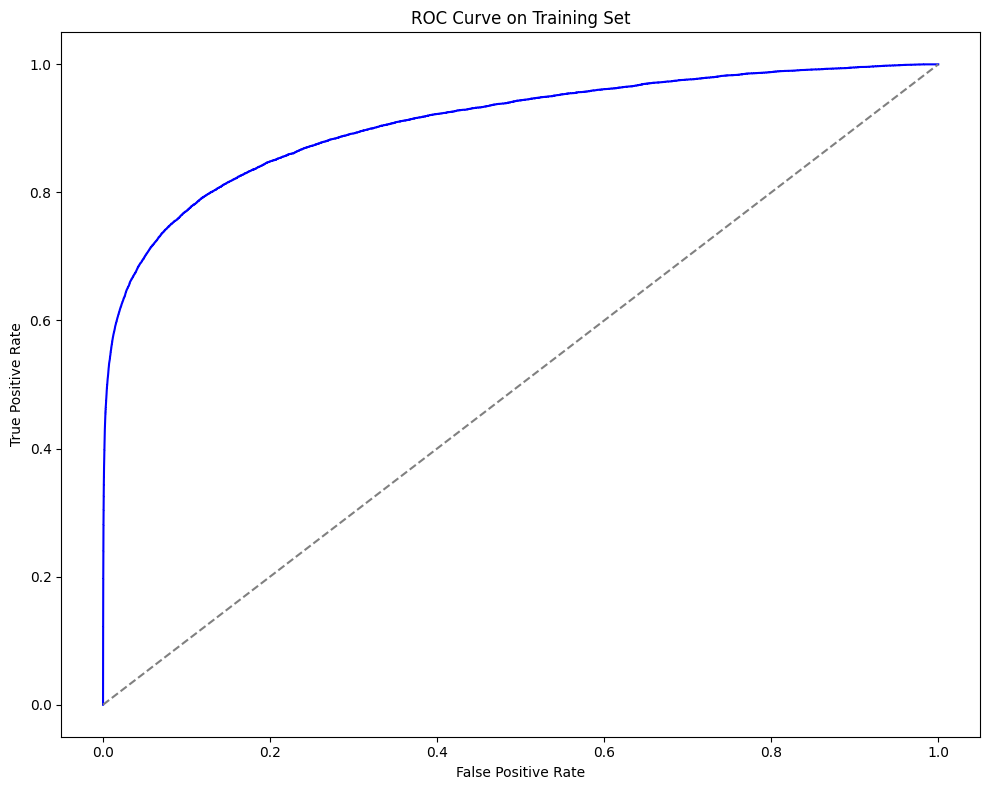

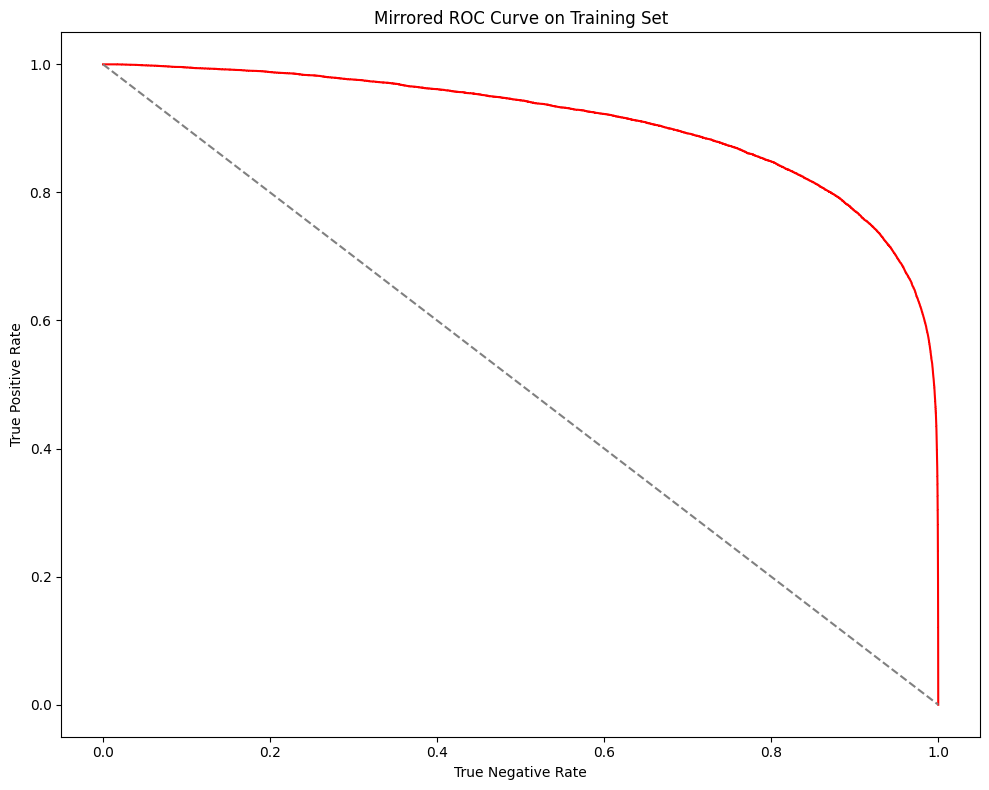

In [26]:
best_pipeline = grid_search.best_estimator_
plot_roc(best_pipeline, X_train, y_train)

In [28]:
log_custom_pymodel(
    run_name="GradientBoost_ImbLearn_Model_Final",
    params=params,
    metrics=metrics,
    best_pipeline=best_pipeline,
    figures=["gradientboost_roc_curve.png", "gradientboost_roc_curve_mirrored.png"]
)

2025/04/29 10:17:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run GradientBoost_ImbLearn_Model_Final at: https://dagshub.com/vvaza22/ml-assignment-2.mlflow/#/experiments/3/runs/f239f83891f142cdbf1ba657ab86aca0
🧪 View experiment at: https://dagshub.com/vvaza22/ml-assignment-2.mlflow/#/experiments/3
